In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Read the data
train_origin = pd.read_csv('/Users/jaesolshin/내 드라이브/2024-2/Google ML Bootcamp2024/data/playground1/train.csv')

In [25]:
from category_encoders import TargetEncoder

# 데이터 샘플링
train = train_origin.sample(frac=0.01, random_state = 42)

# 예측에 필요 없는 'id'와 'Annual_Premium' 변수를 드롭
train = train.drop(columns=['id'])

# 범주형 변수 인코딩
def encoding(train):
    gender_mapping = {'Male': 0, 'Female': 1}
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    vehicle_damage_mapping = {'No': 0, 'Yes': 1}

    train['Gender'] = train['Gender'].map(gender_mapping)
    train['Vehicle_Age'] = train['Vehicle_Age'].map(vehicle_age_mapping)
    train['Vehicle_Damage'] = train['Vehicle_Damage'].map(vehicle_damage_mapping)

    return train

train = encoding(train)

# 범주형 변수 타겟 인코딩
cat_columns = ['Region_Code', 'Policy_Sales_Channel', 'Vintage']
train.loc[:,cat_columns] = train.loc[:,cat_columns].astype('category')

target_encoder = TargetEncoder()
train[cat_columns] = target_encoder.fit_transform(train[cat_columns],train['Response'])

#수치형 변수: Age, Region_Code, Annual Premium, Policy_Sales_Channel, Vintage -> normalize
scaler = MinMaxScaler()
num_columns = ['Age', 'Annual_Premium']
train[num_columns] = scaler.fit_transform(train[num_columns])

# XGBoost에서 발생하는 문제 해결
train.columns = train.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')

# 예측변수 분리 및 train, valid set 분리
X = train.drop(['Response'], axis=1)
y = train['Response']

---------- GridCV ----------

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [13]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [20, 31, 50],
    'max_depth': [-1, 20],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'lambda_l1': [0.0, 0.1],
    'lambda_l2': [0.0, 0.1]
}


# LightGBM 모델 생성
lgbm_model = LGBMClassifier()

# k-fold 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)

# 학습 및 하이퍼파라미터 튜닝
grid_search.fit(X, y)

# 최적의 하이퍼파라미터 출력
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best ROC AUC score found by GridSearchCV:", grid_search.best_score_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightG

In [18]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)

LGBMClassifier(lambda_l1=0.1, lambda_l2=0.1, num_leaves=20)
{'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 20}


Best parameters found by Optuna: {'num_leaves': 31, 'max_depth': 4, 'learning_rate': 0.09052003360634207, 'n_estimators': 200, 'lambda_l1': 0.3182477714588782, 'lambda_l2': 0.4879151959075913}

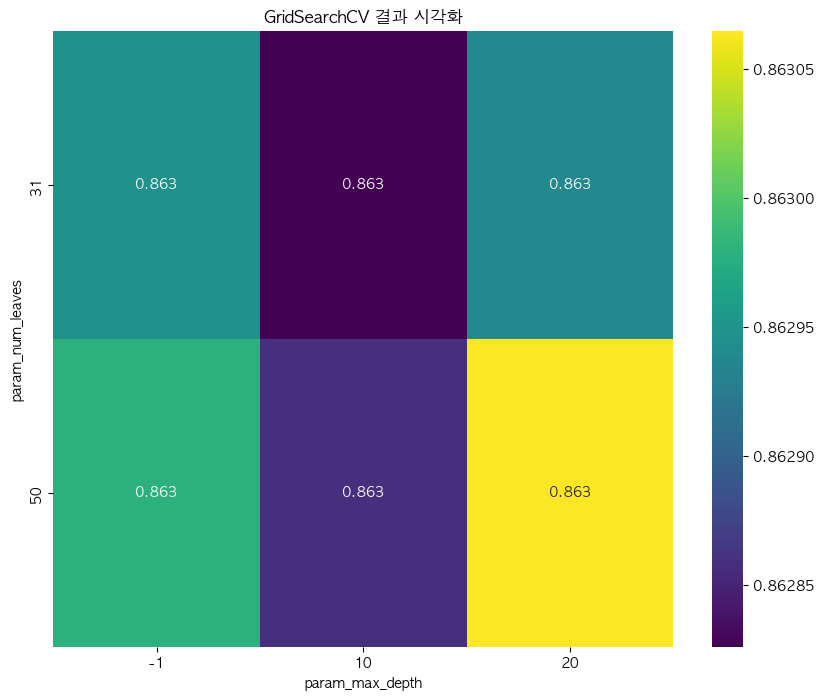

In [ ]:
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 글꼴 설정
plt.rc('font', family='AppleGothic')

# 하이퍼파라미터 조합에 따른 성능 시각화
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(index='param_num_leaves', columns='param_max_depth', values='mean_test_score')

plt.figure(figsize=(10, 8))
plt.title("GridSearchCV 결과 시각화")
plt.xlabel("max_depth")
plt.ylabel("num_leaves")
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
plt.show()

In [20]:
def modeling(model, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state =42)
    train_scores = []
    valid_scores = []

    for fold, (train_index, valid_index) in enumerate(tqdm(skf.split(X_train, y_train), total=skf.get_n_splits(), desc="Folds"), 1):
        X_skf_train, X_skf_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_skf_train, y_skf_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

        model.fit(X_skf_train, y_skf_train)

        train_preds = model.predict_proba(X_skf_train)[:, 1]
        train_auc = roc_auc_score(y_skf_train, train_preds)
        train_scores.append(train_auc)

        valid_preds = model.predict_proba(X_skf_valid)[:, 1]
        valid_auc = roc_auc_score(y_skf_valid, valid_preds)
        valid_scores.append(valid_auc)

        print(f'Fold {fold}: Train ROC AUC: {train_auc:.4f}, Validation ROC AUC: {valid_auc:.4f}')

    print(f'Average Train ROC AUC: {sum(train_scores)/len(train_scores):.4f}')
    print(f'Average Validation ROC AUC: {sum(valid_scores)/len(valid_scores):.4f}')

    X_test_scaled = scaler.transform(X_test)
    test_preds = model.predict_proba(X_test_scaled)[:, 1]
    test_auc = roc_auc_score(y_test, test_preds)
    print(f'Test ROC AUC: {test_auc:.4f}')

    return train_scores, valid_scores, test_auc

---------- by GridCV ----------

In [30]:
# Grid 서치를 통해 찾는 값 적용
print("\nLightGBM with best params:")
lgbm_model = LGBMClassifier(**grid_search.best_params_, random_state=42)
gbm_train_scores, lgbm_valid_scores, lgbm_test_auc = modeling(lgbm_model, X, y)


LightGBM with best params:


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 73630, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122966 -> initscore=-1.964636
[LightGBM] [Info] Start training from score -1.964636
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambd

Folds:  20%|██        | 1/5 [00:02<00:09,  2.42s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Fold 1: Train ROC AUC: 0.8875, Validation ROC AUC: 0.8742
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

Folds:  40%|████      | 2/5 [00:03<00:05,  1.68s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Fold 2: Train ROC AUC: 0.8881, Validation ROC AUC: 0.8719
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

Folds:  60%|██████    | 3/5 [00:04<00:03,  1.51s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Fold 3: Train ROC AUC: 0.8861, Validation ROC AUC: 0.8775
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 9055, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

Folds:  80%|████████  | 4/5 [00:05<00:01,  1.33s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Fold 4: Train ROC AUC: 0.8889, Validation ROC AUC: 0.8702
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 9055, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total B

Folds: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Fold 5: Train ROC AUC: 0.8882, Validation ROC AUC: 0.8719
Average Train ROC AUC: 0.8878
Average Validation ROC AUC: 0.8731
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
Test ROC AUC: 0.8780


---------- hyper opt ----------

In [22]:
# 수동 튜닝 -learning_rate: 0.01, n_estimators: 500, lambda_l2: 1.0
# AUC가 0.0012 상승했으나, 연산시간이 7.8s -> 52.3s
print("\nLightGBM:")
params = {
    'num_leaves': 50,
    'max_depth': -1,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_gain_to_split': 0.0,
    'boosting': 'gbdt',
    'objective': 'binary',  # 이진 분류 문제인 경우
    'metric': 'binary_logloss',
    'verbose': -1
}

lgbm_model = LGBMClassifier(**params, random_state=42)
gbm_train_scores, lgbm_valid_scores, lgbm_test_auc = modeling(lgbm_model, X, y)


LightGBM:


Folds:  20%|██        | 1/5 [00:05<00:20,  5.09s/it]

Fold 1: Train ROC AUC: 0.9317, Validation ROC AUC: 0.8693


Folds:  40%|████      | 2/5 [00:09<00:14,  4.78s/it]

Fold 2: Train ROC AUC: 0.9321, Validation ROC AUC: 0.8694


Folds:  60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Fold 3: Train ROC AUC: 0.9312, Validation ROC AUC: 0.8746


Folds:  80%|████████  | 4/5 [00:17<00:04,  4.30s/it]

Fold 4: Train ROC AUC: 0.9328, Validation ROC AUC: 0.8651


Folds: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it]

Fold 5: Train ROC AUC: 0.9316, Validation ROC AUC: 0.8680
Average Train ROC AUC: 0.9319
Average Validation ROC AUC: 0.8693


Test ROC AUC: 0.8725


---------- hyperopt ----------

In [28]:
params_hyperopt = {'lambda_l1': 1.6175669300438162, 'lambda_l2': 0.43373935171414857, 'learning_rate': 0.06201014808078723, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 100}

lgbm_model = LGBMClassifier(**params_hyperopt, random_state=42)
gbm_train_scores, lgbm_valid_scores, lgbm_test_auc = modeling(lgbm_model, X, y)


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857


[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 73630, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122966 -> initscore=-1.964636
[LightGBM] [Info] Start training from score -1.964636
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: 

Folds:  20%|██        | 1/5 [00:03<00:13,  3.36s/it]

[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
Fold 1: Train ROC AUC: 0.9130, Validation ROC AUC: 0.8715
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

Folds:  40%|████      | 2/5 [00:07<00:11,  3.83s/it]

[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
Fold 2: Train ROC AUC: 0.9121, Validation ROC AUC: 0.8705
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ove

Folds:  60%|██████    | 3/5 [00:09<00:06,  3.00s/it]

[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
Fold 3: Train ROC AUC: 0.9111, Validation ROC AUC: 0.8764
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Info] Number of positive: 9055, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ove

Folds:  80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

Fold 4: Train ROC AUC: 0.9137, Validation ROC AUC: 0.8667
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
[LightGBM] [Info] Number of positive: 9055, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 73631, number of 

Folds: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]

[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857
Fold 5: Train ROC AUC: 0.9122, Validation ROC AUC: 0.8686
Average Train ROC AUC: 0.9124
Average Validation ROC AUC: 0.8707
[LightGBM] [Warning] lambda_l1 is set=1.6175669300438162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6175669300438162
[LightGBM] [Warning] lambda_l2 is set=0.43373935171414857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43373935171414857


Test ROC AUC: 0.8756


In [29]:
params_optuna = {'num_leaves': 31, 'max_depth': 4, 'learning_rate': 0.09052003360634207, 'n_estimators': 200, 'lambda_l1': 0.3182477714588782, 'lambda_l2': 0.4879151959075913}

lgbm_model = LGBMClassifier(**params_optuna, random_state=42)
gbm_train_scores, lgbm_valid_scores, lgbm_test_auc = modeling(lgbm_model, X, y)


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 73630, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122966 -> initscore=-1.964636
[LightGBM] [Info] Start trai

Folds:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
Fold 1: Train ROC AUC: 0.8862, Validation ROC AUC: 0.8750
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

Folds:  40%|████      | 2/5 [00:04<00:07,  2.41s/it]

[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
Fold 2: Train ROC AUC: 0.8862, Validation ROC AUC: 0.8726
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Info] Number of positive: 9054, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

Folds:  60%|██████    | 3/5 [00:07<00:04,  2.28s/it]

[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
Fold 3: Train ROC AUC: 0.8848, Validation ROC AUC: 0.8785
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Info] Number of positive: 9055, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

Folds:  80%|████████  | 4/5 [00:09<00:02,  2.19s/it]

[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
Fold 4: Train ROC AUC: 0.8875, Validation ROC AUC: 0.8710
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
[LightGBM] [Info] Number of positive: 9055, number of negative: 64576
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

Folds: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]

[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782
[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
Fold 5: Train ROC AUC: 0.8867, Validation ROC AUC: 0.8720
Average Train ROC AUC: 0.8863
Average Validation ROC AUC: 0.8738
[LightGBM] [Warning] lambda_l1 is set=0.3182477714588782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3182477714588782


[LightGBM] [Warning] lambda_l2 is set=0.4879151959075913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4879151959075913
Test ROC AUC: 0.8778


By GridCV: 0.8780
{'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 20}

By Hand: 0.8725
{'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 200, 'min_data_in_leaf': 20, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'min_gain_to_split': 0.0, 'boosting': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'verbose': -1}

By HyperOpt: 0.8756
{'lambda_l1': 1.6175669300438162, 'lambda_l2': 0.43373935171414857, 'learning_rate': 0.06201014808078723, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 100}

By Optuna: 0.8778
{'num_leaves': 31, 'max_depth': 4, 'learning_rate': 0.09052003360634207, 'n_estimators': 200, 'lambda_l1': 0.3182477714588782, 'lambda_l2': 0.4879151959075913}
